# Loss versus Robustness tradeoffs -- Plots

This notebook is used to generate Figure 5 of the paper "Robust Consensus in Ranking Data Analysis: Definitions, Properties and Computational Issues"

The fist cells load the relevant librairies and define the relevant functions.

The next cells load the results.

The last cell outputs the plot.

### Librairies

In [ ]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt
import os
from app.launcher_classic import torch_dist, proba_plackett_luce, pairwise_matrix
from app.launcher_classic import plot_end_training as plot_end_training_classic
from app.launcher_classic import torch_dist as torch_dist_classic

device = "cpu"
default_tensor_type = torch.FloatTensor

In [2]:
%load_ext autoreload
%autoreload 2

### Useful functions

In [3]:
def get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix="", folder_path=None):
    if folder_path == None:
        folder_path = f"{os.getcwd()}/perf_robustness_profile/"+prefix
    filename = f"perf_robustness_dist={dist}_w={w}_delta={delta}_epochs={epochs}_dist_type_sym={dist_type_sym}_norm_L{norm_type}.pt"
    return folder_path+filename

def get_res(mypath, dist, torch_all_ranks, plot_training=False, n=4, choose_val="full"):
    
    perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, thresholds = load_plot_exp(mypath, dist, torch_all_ranks, plot_training=plot_training, n=n)
    
    print(f"perf_list = {perf_list} \n\n eps_list1 (l1 norm) = {eps_list1}  \n eps_list2 (l2 norm) = {eps_list2} \n\n alt_eps_list1 (l1 norm) = {alt_eps_list1}  \n alt_eps_list2 (l2 norm) = {alt_eps_list2} \n\n")
    
    l1_norm = list()
    for i in range(len(eps_list1)):
        minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) ) 
        maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) ) 
        if choose_val == "full":
            l1_norm.append(torch.tensor(eps_list1[i]))
        elif choose_val == "alt":
            l1_norm.append(torch.tensor(alt_eps_list1[i]))
        elif choose_val == "min":
            l1_norm.append(minval)
        elif choose_val == "max":
            l1_norm.append(maxval)

    l2_norm = list()
    for i in range(len(eps_list2)):
        minval = torch.min( torch.tensor(eps_list2[i]), torch.tensor(alt_eps_list2[i]) ) 
        maxval = torch.max( torch.tensor(eps_list2[i]), torch.tensor(alt_eps_list2[i]) ) 
        if choose_val == "full":
            l2_norm.append(torch.tensor(eps_list2[i]))
        elif choose_val == "alt":
            l2_norm.append(torch.tensor(alt_eps_list2[i]))
        elif choose_val == "min":
            l2_norm.append(minval)
        elif choose_val == "max":
            l2_norm.append(maxval)
    
    return perf_list, l1_norm, l2_norm

def load_plot_exp(path, dist, torch_all_ranks, plot_training=False, n=4):
    dict_res = torch.load(path)
    training_dict = dict_res['training_dict']
    final_val_dict = dict_res['final_val_dict']
    epochs = int(path.split('epochs=')[1].split('_')[0])
    p_torch=final_val_dict['p_torch']
    print(f"PTORCh = {p_torch}")
    
    for i, threshold in enumerate(training_dict.keys()):
        qlist_ = training_dict[threshold]['qs_'][epochs-10000:]
        q1 = np.mean(qlist_, axis=0)
        q2 = training_dict[threshold]['mean_qs'][-1]
        p_torch=final_val_dict['p_torch']
    
    if plot_training:
        for threshold in list(training_dict.keys()):
            if type_ == "classic":
                dist_Tp_Tq = lambda _p,_q: torch_dist_classic(dist, _p, _q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
            elif type_ == "pairwise":
                dist_Tp_Tq = lambda _P,_Q: torch_dist_pairwise(dist, _P, _Q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
            
            norms_ = training_dict[threshold]['norms']
            losses = training_dict[threshold]['losses']
            mean_qs_=training_dict[threshold]['mean_qs']
            phis_=training_dict[threshold]['phis']
            mean_phi2_=training_dict[threshold]['mean_phi2']
            lambdas_=training_dict[threshold]['lambdas']
            mean_lambdas_=training_dict[threshold]['mean_lambdas']
            grad_data=training_dict[threshold]['grad_data']
            freq_phi_=training_dict[threshold]['freq_phi']
            p_torch=final_val_dict['p_torch']
            print(f"load plot n = {n}, ptorch = {p_torch.shape}, all ranks = {torch_all_ranks.shape}")
            P=pairwise_matrix(p_torch, torch_all_ranks, n=n)
            
            plot_end_training_classic(p_torch=p_torch, dist_Tp_Tq=dist_Tp_Tq, norms_=norms_, losses=losses, mean_qs_=mean_qs_, phis_=phis_, mean_phi2_=mean_phi2_, lambdas_=lambdas_, mean_lambdas_=mean_lambdas_, grad_data=grad_data, norm_type=norm_type)
    return final_val_dict["perf_list"], final_val_dict["eps_list1"], final_val_dict["eps_list2"], final_val_dict["alt_eps_list1"], final_val_dict["alt_eps_list2"], final_val_dict["thresholds"]

def get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, choose_val="full", thresholds=np.linspace(0,0.5,11)):
    
    perf_list_res = list()
    l1_norm_res = list()
    
    for i, (my_path, dist) in enumerate(zip(my_paths, dists)):
        print(f"File path = {my_path}")
        perf_list, l1_norm, l2_norm = get_res(my_path, dist, torch_all_ranks, plot_training=plot_training, n=n, choose_val=choose_val)
        perf_res_ = perf_list[0]/(n*(n-1)/2)
        l1_norm_res_ = l1_norm[0].item()/2
        print(f"Results: perf = {perf_res_} and robustness = {l1_norm_res_}")
        perf_list_res.append(perf_res_)
        l1_norm_res.append(l1_norm_res_)
    
    return perf_list_res, l1_norm_res


### Load experiments

In [4]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

# Unchanged parameters
delta = 1
dist_type_sym = False
norm_type = "1"
choose_val = "full"
thresholds = np.array([0.05])
dists = ["erm", "maxpair"]

##### Random Plackett-Luce 1

In [ ]:
# Rerun the exp --> You will need to change "epochs" and "w" in the next cell
# %run app/launcher_classic.py --seed_vals "18" --epochs_list "20000"

In [ ]:
# Basic (mostly unchanged) parameters
epochs = 20001
prefix = "unimodal/"
n_items = 4

# To copy paste from the name of the saved file
w = f"[1.1173979 1.0336659 0.6316072 0.3937561]"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_18, tv_dist_18 = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val=choose_val)

                      

##### Random Plackett-Luce 2

In [ ]:
# Rerun the exp --> You will need to change "epochs" and "w" in the next cell
# %run app/launcher_classic.py --seed_vals "283" --epochs_list "20000"

In [ ]:
# Basic (mostly unchanged) parameters
epochs = 20001
prefix = "unimodal/"

# To copy-paste from the name of the file
w = f"[1.7226691  0.6500638  0.09824223 0.09391503]"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_283, tv_dist_283 = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val=choose_val)
print(perf_283, tv_dist_283)


##### Random Plackett-Luce 3

In [ ]:
# Rerun the exp --> You will need to change "epochs" and "w" in the next cell
# %run app/launcher_classic.py --seed_vals "1903" --epochs_list "20000"

In [ ]:
# Basic (mostly unchanged) parameters
epochs = 20001
prefix = "unimodal/"

# To copy-paste from the name of the file
w = f"[2.7095466  1.1030647  0.98387283 0.3974442]"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_1903, tv_dist_1903 = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val=choose_val)
print(perf_1903, tv_dist_1903)


##### Bucket 1

In [ ]:
# Rerun the exp
# %run app/launcher_classic.py --seed_vals "279" --exp_types "two_untied" --epochs_list "20000" --gap_mode "0.01" --mixture_val "0.95"

In [ ]:
# Basic (mostly unchanged) parameters
epochs = 20001
prefix = "two_untied/"

w = "two_untied_mix=0.95_gap=0.01_seed=279"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_bucket_001, tv_dist_bucket_001 = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=thresholds, choose_val=choose_val)
print(perf_bucket_001, tv_dist_bucket_001)



##### Bucket 2

In [ ]:
# Rerun the exp
# %run app/launcher_classic.py --seed_vals "279" --exp_types "two_untied" --epochs_list "20000" --gap_mode "0.1" --mixture_val "1"

In [ ]:
# Basic (mostly unchanged) parameters
epochs = 20001
prefix = "two_untied/"

w = "two_untied_mix=1_gap=0.1_seed=279"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_bucket_01, tv_dist_bucket_01 = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=thresholds, choose_val=choose_val)
print(perf_bucket_01, tv_dist_bucket_01)



##### Almost uniform

In [54]:
# Rerun the exp
# %run app/launcher_classic.py --seed_vals "279" --ms "0.01" --epochs_list "20000"

In [ ]:
# Basic (mostly unchanged) parameters
epochs = 20001
prefix = "unimodal/"

w = f"[0.99852407 0.9910795  0.9796387  0.97639084]"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_uniform, tv_dist_uniform = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=thresholds, choose_val=choose_val)
print(perf_uniform, tv_dist_uniform)



##### Almost point mass

In [ ]:
# Rerun the exp
# %run app/launcher_classic.py --seed_vals "279" --ms "10" --epochs_list "20000"

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20002
prefix = "unimodal/"

w = f"[2.2831823e-01 1.2837668e-04 1.1639423e-09 4.2043390e-11]"

my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, prefix=prefix) for dist in dists]
perf_dirac, tv_dist_dirac = get_pair_results(my_paths, dists, torch_all_ranks, plot_training=False, n=4, thresholds=thresholds, choose_val=choose_val)
print(perf_dirac, tv_dist_dirac)



### Generate plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


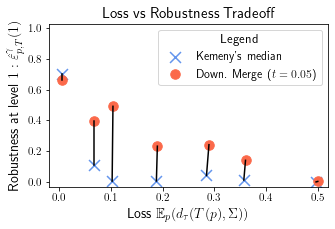

In [31]:
cm = plt.cm.get_cmap('Reds')
myred = cm(1/2)

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
        })

plt.figure(figsize=(5,3))

median_res_x = [perf_18[0], perf_283[0], perf_1903[0], perf_bucket_001[0], perf_bucket_01[0], perf_uniform[0], perf_dirac[0]]
median_res_y = [tv_dist_18[0], tv_dist_283[0], tv_dist_1903[0], tv_dist_bucket_001[0], tv_dist_bucket_01[0], tv_dist_uniform[0], tv_dist_dirac[0]]

maxpair_res_x = [perf_18[1], perf_283[1], perf_1903[1], perf_bucket_001[1], perf_bucket_01[1], perf_uniform[1], perf_dirac[1]]
maxpair_res_y = [tv_dist_18[1], tv_dist_283[1], tv_dist_1903[1], tv_dist_bucket_001[1], tv_dist_bucket_01[1], tv_dist_uniform[1], tv_dist_dirac[1]]

plt.plot(perf_18, tv_dist_18, "-", c="black")
plt.plot(perf_283, tv_dist_283, "-", c="black")
plt.plot(perf_1903, tv_dist_1903, "-", c="black")
plt.plot(perf_bucket_001, tv_dist_bucket_001, "-", c="black")
plt.plot(perf_bucket_01, tv_dist_bucket_01, "-", c="black")
plt.plot(perf_uniform, tv_dist_uniform, "-", c="black")
plt.plot(perf_dirac, tv_dist_dirac, "-", c="black")

plt.scatter(median_res_x, median_res_y, s=120, c="cornflowerblue", marker="x", label="Kemeny's median")
plt.scatter(maxpair_res_x, maxpair_res_y, s=90, c=myred, marker="o", label=r"Down. Merge ($t=0.05$)")
plt.xlabel(r"Loss $\mathbb{E}_p(d_{\tau}(T(p), \Sigma))$", fontsize=14)
plt.ylabel(r"Robustness at level $1: \hat{\varepsilon}^{\gamma}_{p,T}(1)$", fontsize=14)
plt.title(f"Loss vs Robustness Tradeoff", fontsize=15)
legend = plt.legend(title="Legend", fontsize=12)
legend.get_title().set_fontsize('13')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim((-0.02, 0.52))
plt.ylim((-0.03, 1.03))
plt.show()